In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
!pip install sklearn-crfsuite

     |████████████████████████████████| 747kB 8.4MB/s 


In [4]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

## Let's use CoNLL 2002 data to build a NER system

CoNLL2002 corpus is available in NLTK. We use Spanish data.

In [5]:
import nltk
nltk.download('conll2002')
nltk.corpus.conll2002.fileids()

[nltk_data] Downloading package conll2002 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2002.zip.


['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [6]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

CPU times: user 1.68 s, sys: 93.5 ms, total: 1.78 s
Wall time: 1.78 s


In [7]:
print('wielkosć zbioru treningowego:', len(train_sents))
print('wielkosć zbioru testowego:' , len(test_sents))
train_sents[10]
# opis znaczeń tagów: https://freeling-user-manual.readthedocs.io/es/latest/tagsets/tagset-en/

wielkosć zbioru treningowego: 8323
wielkosć zbioru testowego: 1517


[('Izquierda', 'NC', 'B-ORG'),
 ('Unida', 'AQ', 'I-ORG'),
 ('de', 'SP', 'I-ORG'),
 ('Santander', 'NC', 'I-ORG'),
 ('presentó', 'VMI', 'O'),
 ('hoy', 'RG', 'O'),
 ('su', 'DP', 'O'),
 ('nuevo', 'AQ', 'O'),
 ('boletín', 'NC', 'O'),
 ('trimestral', 'AQ', 'O'),
 ('"', 'Fe', 'O'),
 ('Ciudad', 'NC', 'B-MISC'),
 ('"', 'Fe', 'O'),
 (',', 'Fc', 'O'),
 ('una', 'DI', 'O'),
 ('publicación', 'NC', 'O'),
 ('de', 'SP', 'O'),
 ('la', 'DA', 'O'),
 ('que', 'PR', 'O'),
 ('se', 'P0', 'O'),
 ('distribuirán', 'VMI', 'O'),
 ('10.000', 'Z', 'O'),
 ('ejemplares', 'NC', 'O'),
 ('preferentemente', 'RG', 'O'),
 ('en', 'SP', 'O'),
 ('los', 'DA', 'O'),
 ('barrios', 'NC', 'O'),
 ('del', 'SP', 'O'),
 ('municipio', 'NC', 'O'),
 ('donde', 'PR', 'O'),
 ('la', 'DA', 'O'),
 ('colación', 'NC', 'O'),
 ('cuenta', 'VMI', 'O'),
 ('con', 'SP', 'O'),
 ('mayor', 'AQ', 'O'),
 ('respaldo', 'NC', 'O'),
 ('ciudadano', 'AQ', 'O'),
 ('.', 'Fp', 'O')]

In [ ]:
#nltk.help.upenn_tagset() #używany w nltk tagset angielski

In [8]:
#proszę wylistować wszystkie występujące w zbiorze treningowym tagi (2 kolumna) i etykiety (3 kolumna)
labl={}
tagl={}
for s in train_sents:
    for w in s:
        try:
            labl[w[2]]+=1
        except KeyError:
            labl[w[2]]=1
        try:
            tagl[w[1]]+=1
        except KeyError:
            tagl[w[1]]=1
#labl=sorted(labl)
#tagl=sorted(tagl)

In [9]:
print(labl)
print(tagl)
print(sorted(labl))
print(sorted(tagl))

{'B-LOC': 4913, 'O': 231920, 'B-ORG': 7390, 'B-PER': 4321, 'I-PER': 3903, 'B-MISC': 2173, 'I-ORG': 4992, 'I-LOC': 1891, 'I-MISC': 3212}
{'NP': 1150, 'Fpa': 2094, 'Fpt': 2099, 'Fc': 14716, 'Z': 6589, 'NC': 64326, 'Fp': 7263, 'Fg': 1582, 'DA': 25679, 'AQ': 22418, 'SP': 44022, 'VMI': 14036, 'RG': 5306, 'VMN': 4664, 'DI': 5520, 'PR': 5194, 'CS': 4648, 'P0': 2539, 'VMS': 1147, 'CC': 6248, 'PP': 950, 'VAN': 104, 'VMP': 2618, 'DD': 1624, 'VAI': 1838, 'VSP': 186, 'PN': 512, 'VMM': 620, 'DP': 2048, 'RN': 1156, 'PI': 626, 'VSI': 1588, 'VSS': 123, 'VMG': 377, 'Fe': 5691, 'DN': 1317, 'AO': 878, 'Fz': 105, 'Fd': 195, 'Fx': 132, 'I': 95, 'VSN': 207, 'PD': 171, 'Fs': 20, 'PT': 71, 'VAS': 86, 'Fia': 15, 'Fit': 15, 'Fh': 43, 'VSG': 20, 'PX': 3, 'VAP': 13, 'DT': 10, 'Y': 8, 'Fat': 2, 'VSM': 2, 'Faa': 1, 'Ft': 4, 'VAM': 1}
['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
['AO', 'AQ', 'CC', 'CS', 'DA', 'DD', 'DI', 'DN', 'DP', 'DT', 'Faa', 'Fat', 'Fc', 'Fd', 'Fe', 'Fg', 'Fh',

## Features

Next, define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used. 

This makes a simple baseline, but you certainly can add and remove some features to get (much?) better results - experiment with it.

sklearn-crfsuite (and python-crfsuite) supports several feature formats; here we use feature dicts.

In [35]:
def num_there(s):
    return any(i.isdigit() for i in s)

num_there("kdsjak23")
len("aaa")
"aaa"[0:3]
"aabbccdd"[-2:]
",".isalpha()
"012"[0:2]

'01'

In [36]:
# OPCJA 1
# nowe cechy: 
#1. czy posiada liczbę
#2. długość stringa
#3. pierwsze 2 litery
#4. czy poprzednia/następny to cyfra
#5. czy poprzednia/następna to litery alfabetu

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-2:]': word[-2:],
        'word[0:2]': word[0:2],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'num_there(word)': num_there(word),
        'len(word)': len(word),
        'postag': postag,
      
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.isupper()': word1.istitle(),
            '-1:word.isdigit()': word1.isdigit(),
            '-1:word.isalpha()': word1.isalpha(),
            'pos-1':postag1
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.isupper()': word1.istitle(),
            '+1:word.isdigit()': word1.isdigit(),
            '+1:word.isalpha()': word1.isalpha()
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [51]:
# OPCJA 2
# nowe cechy: 
#1. czy posiada liczbę
#2. długość stringa poprzedniego/następnego/obecnego
#3. pierwsze 3 litery
#4. czy poprzednia/następny to cyfra
#5. czy poprzednia/następna to litery alfabetu

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-2:]': word[-2:],
        'word[0:3]': word[0:3],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'num_there(word)': num_there(word),
        'len(word)': len(word),
        'postag': postag,
      
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.isupper()': word1.istitle(),
            '-1:word.isdigit()': word1.isdigit(),
            '-1:word.isalpha()': word1.isalpha(),
            '-1:len(word)': len(word1),
            'pos-1':postag1
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.isupper()': word1.istitle(),
            '+1:word.isdigit()': word1.isdigit(),
            '+1:word.isalpha()': word1.isalpha(),
            '+1:len(word)': len(word1)
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

This is what word2features extracts:

In [52]:
print(train_sents[0])
sent2features(train_sents[0])[1]

[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


{'+1:len(word)': 9,
 '+1:word.isalpha()': True,
 '+1:word.isdigit()': False,
 '+1:word.isupper()': True,
 '+1:word.lower()': 'australia',
 '-1:len(word)': 9,
 '-1:word.isalpha()': True,
 '-1:word.isdigit()': False,
 '-1:word.isupper()': True,
 '-1:word.lower()': 'melbourne',
 'bias': 1.0,
 'len(word)': 1,
 'num_there(word)': False,
 'pos-1': 'NP',
 'postag': 'Fpa',
 'word.isdigit()': False,
 'word.istitle()': False,
 'word.isupper()': False,
 'word.lower()': '(',
 'word[-2:]': '(',
 'word[0:3]': '('}

Extract features from the data:

In [53]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 1.71 s, sys: 394 ms, total: 2.11 s
Wall time: 2.11 s


## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [ ]:
 #help(sklearn_crfsuite.CRF)

In [54]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, #0-1 -> raczej niższe
    c2=0.1, #0-1
    max_iterations=100, #ilość iteracji, 100 trwa około 30 sekund 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 47.6 s, sys: 50.5 ms, total: 47.6 s
Wall time: 47.6 s


## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [15]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [16]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels) #f1 ważone częstością występowania, nie uwzględniając etykiety "O" bo jest ich duża nadreprezentacja

0.7946395332266392

Inspect per-class results in more detail:

In [17]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-LOC      0.812     0.777     0.794      1084
       I-LOC      0.691     0.674     0.682       325
      B-MISC      0.725     0.537     0.617       339
      I-MISC      0.672     0.576     0.620       557
       B-ORG      0.813     0.832     0.822      1400
       I-ORG      0.853     0.786     0.818      1104
       B-PER      0.840     0.891     0.865       735
       I-PER      0.892     0.946     0.918       634

   micro avg      0.810     0.785     0.798      6178
   macro avg      0.787     0.752     0.767      6178
weighted avg      0.807     0.785     0.795      6178



## Hyperparameter Optimization

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

I takes quite a lot of CPU time and RAM (we're fitting a model ``50 * 3 = 150`` times), so grab a tea and be patient, or reduce n_iter in RandomizedSearchCV, or fit model only on a subset of training data.

In [18]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf,            #wyszukiwanie kombinacji parametrów
                        params_space, 
                        cv=3,           #3 zbiory do cross-validation
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=10,   #10 prób losowo próbowanych kombinacji c1 oraz c2 = 15 minut 
                        scoring=f1_scorer)

rs.fit(X_train, y_train) # dostaniemy najlepsze parametry c1 / c2

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-a48c477186d1>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "# define fixed parameters and parameters to search\ncrf = sklearn_crfsuite.CRF(\n    algorithm='lbfgs', \n    max_iterations=100, \n    all_possible_transitions=True\n)\nparams_space = {\n    'c1': scipy.stats.expon(scale=0.5),\n    'c2': scipy.stats.expon(scale=0.05),\n}\n\n# use the same metric for evaluation\nf1_scorer = make_scorer(metrics.flat_f1_score, \n                        average='weighted', labels=labels)\n\n# search\nrs = RandomizedSearchCV(crf,            #wyszukiwanie kombinacji parametrów\n                        params_space, \n                        cv=3,           #3 zbiory do cross-validation\n                        verbose=1, \n                        n_jobs=-1, \n 

KeyboardInterrupt: ignored

Best result:

In [ ]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.1914222063514142, 'c2': 0.028518558048064052}
best CV score: 0.7444225620925201
model size: 1.06M


### Check parameter space

A chart which shows which ``c1`` and ``c2`` values have RandomizedSearchCV checked. Red color means better results, blue means worse.

Dark blue => 0.7028, dark red => 0.7444


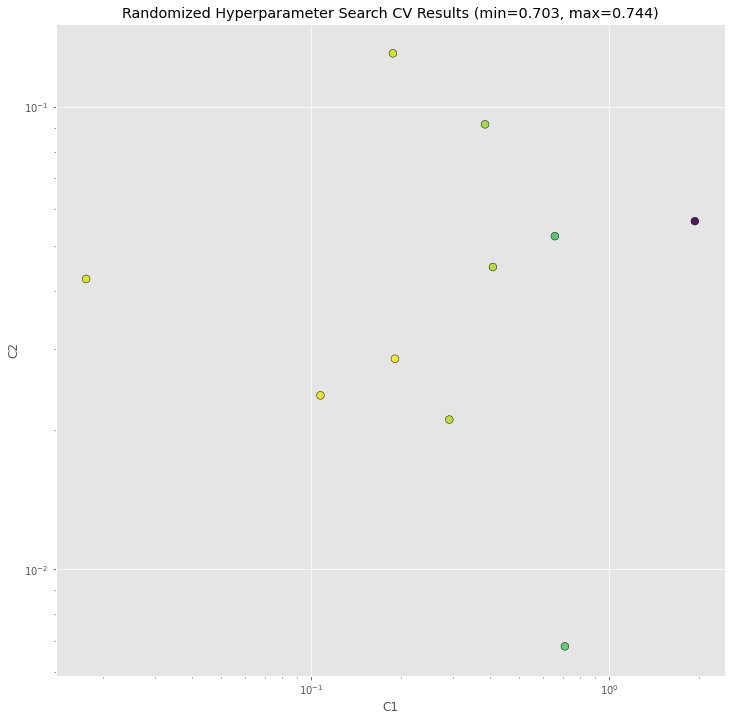

In [ ]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Check best estimator on our test data

As you can see, quality is improved.

In [ ]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-LOC      0.797     0.774     0.785      1084
       I-LOC      0.666     0.662     0.664       325
      B-MISC      0.713     0.534     0.610       339
      I-MISC      0.668     0.564     0.611       557
       B-ORG      0.811     0.826     0.818      1400
       I-ORG      0.840     0.781     0.809      1104
       B-PER      0.831     0.880     0.855       735
       I-PER      0.886     0.942     0.913       634

   micro avg      0.801     0.779     0.790      6178
   macro avg      0.776     0.745     0.758      6178
weighted avg      0.798     0.779     0.787      6178



## Let's check what classifier learned

In [ ]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-PER  -> I-PER   6.378978
I-MISC -> I-MISC  6.320245
I-ORG  -> I-ORG   5.860545
B-LOC  -> I-LOC   5.553477
B-ORG  -> I-ORG   5.486598
B-MISC -> I-MISC  5.076601
I-PER  -> I-PER   4.964020
I-LOC  -> I-LOC   4.927105
O      -> O       3.539062
O      -> B-MISC  2.619639
O      -> B-ORG   2.457916
O      -> B-PER   1.740945
O      -> B-LOC   1.266073
B-ORG  -> O       0.004083
B-LOC  -> B-LOC   -0.045587
B-PER  -> O       -0.130477
I-PER  -> B-LOC   -0.210908
I-ORG  -> O       -0.458894
B-LOC  -> O       -0.643208
I-LOC  -> O       -0.709439

Top unlikely transitions:
B-MISC -> I-LOC   -3.040416
B-LOC  -> I-ORG   -3.056277
I-LOC  -> B-PER   -3.134422
B-ORG  -> B-MISC  -3.134814
I-LOC  -> B-LOC   -3.207932
I-LOC  -> I-ORG   -3.211684
I-MISC -> B-ORG   -3.367299
I-ORG  -> B-LOC   -3.372592
I-MISC -> B-LOC   -3.386278
I-MISC -> I-LOC   -3.480351
I-PER  -> B-ORG   -3.560670
B-ORG  -> B-ORG   -3.818625
I-MISC -> I-ORG   -3.897067
B-PER  -> B-PER   -3.907415
B-MISC -> B

We can see that, for example, it is very likely that the beginning of an organization name (B-ORG) will be followed by a token inside organization name (I-ORG), but transitions to I-ORG from tokens with other labels are penalized.

Check the state features:

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
10.796855 B-ORG    word.lower():psoe-progresistas
9.992604 O        word.lower():r.
7.386583 B-PER    word.lower():mcmanaman
7.235921 B-ORG    word.lower():petrobras
7.117186 B-ORG    word.lower():coag-extremadura
6.716229 B-ORG    word[-2:]:-e
6.581741 O        bias
6.416178 O        word.lower():b
6.416178 O        word[-2:]:B
6.089423 O        word.lower():c
6.003133 B-ORG    word.lower():ciu
6.003133 B-ORG    word[-2:]:iU
5.988865 B-MISC   word.lower():cc2305001730
5.976495 B-ORG    +1:word.lower():plasencia
5.968305 B-ORG    -1:word.lower():distancia
5.675564 B-LOC    word.lower():partenón
5.647035 O        word[-2:]:V
5.636666 B-LOC    +1:word.lower():finalizaron
5.543899 O        word.lower():v
5.515547 O        word.lower():mayo
5.433076 B-MISC   word.lower():diversia
5.429710 B-LOC    -1:word.lower():cantabria
5.417582 B-ORG    word.lower():fitchibca
5.406014 B-MISC   word.lower():competencia
5.350980 O        word[-2:]:C
5.347097 B-ORG    word.lower():ongs
5.347



Some observations: (from previous runs, more iterations)

   * the model remembered names of some entities - maybe it is overfit, or maybe our features are not adequate, or maybe remembering is indeed helpful;
   * "calle" is a street in Spanish; model learns that if a previous word was "calle" then the token is likely a part of location;
   *  UPPERCASED or TitleCased words are likely entities of some kind;
   * proper nouns (NP is a proper noun in the Spanish tagset) are often entities.

What to do next

    * Load 'testa' Spanish data.
    * Use it to develop better features and to find best model parameters.
    * Apply the model to 'testb' data again.





In [44]:
#krosswalidacja
from sklearn.model_selection import KFold
import numpy

A = numpy.array([[1, 2], [3, 4], [1, 2], [3, 4], [5,6],[7,8]])
b = numpy.array([1, 2, 3, 4,5,6])
kf = KFold(n_splits=3)
kf.get_n_splits(A)
print(kf)
#KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(A):
     print("TRAIN:", train_index, "TEST:", test_index)
     b_train, b_test = b[train_index], b[test_index]

KFold(n_splits=3, random_state=None, shuffle=False)
TRAIN: [2 3 4 5] TEST: [0 1]
TRAIN: [0 1 4 5] TEST: [2 3]
TRAIN: [0 1 2 3] TEST: [4 5]


In [45]:
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
y_pred_all=[]
for train_index, test_index in kf.split(X_train):
    X_tr, X_tst = numpy.array(X_train)[train_index], numpy.array(X_train)[test_index]
    y_tr, y_tst = numpy.array(y_train)[train_index], numpy.array(y_train)[test_index]
    #print(train_index[1])
    #print(X_train[test_index[0]])
    crf.fit(X_tr, y_tr)
    y_pred = crf.predict(X_tst)
    print("fold")
    print(metrics.flat_classification_report(y_tst, y_pred, labels=sorted_labels, digits=3))
    y_pred_all.extend(y_pred)
print("all results")
print(metrics.flat_classification_report(y_train, y_pred_all, labels=sorted_labels, digits=3))
  
  

fold
              precision    recall  f1-score   support

       B-LOC      0.779     0.812     0.795      1539
       I-LOC      0.758     0.642     0.695       497
      B-MISC      0.635     0.431     0.514       719
      I-MISC      0.536     0.474     0.503       889
       B-ORG      0.813     0.808     0.810      2235
       I-ORG      0.765     0.808     0.786      1543
       B-PER      0.848     0.848     0.848      1230
       I-PER      0.897     0.940     0.918      1062

   micro avg      0.779     0.761     0.770      9714
   macro avg      0.754     0.720     0.734      9714
weighted avg      0.772     0.761     0.765      9714

fold
              precision    recall  f1-score   support

       B-LOC      0.761     0.737     0.749      1732
       I-LOC      0.699     0.621     0.658       752
      B-MISC      0.675     0.513     0.583       746
      I-MISC      0.561     0.450     0.499      1180
       B-ORG      0.790     0.747     0.768      2581
       I-ORG  

Budowa końcowego modelu na całych danych treningowych i testowanie na danych testowych

In [46]:
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
print("wynik na danych testowych")
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

wynik na danych testowych
              precision    recall  f1-score   support

       B-LOC      0.798     0.776     0.787      1084
       I-LOC      0.655     0.637     0.646       325
      B-MISC      0.686     0.534     0.600       339
      I-MISC      0.684     0.582     0.629       557
       B-ORG      0.818     0.826     0.822      1400
       I-ORG      0.855     0.786     0.819      1104
       B-PER      0.839     0.888     0.863       735
       I-PER      0.892     0.953     0.921       634

   micro avg      0.807     0.783     0.795      6178
   macro avg      0.778     0.748     0.761      6178
weighted avg      0.803     0.783     0.792      6178



WYNIKI OPCJI 2


In [55]:
#krosswalidacja
from sklearn.model_selection import KFold
import numpy

A = numpy.array([[1, 2], [3, 4], [1, 2], [3, 4], [5,6],[7,8]])
b = numpy.array([1, 2, 3, 4,5,6])
kf = KFold(n_splits=3)
kf.get_n_splits(A)
print(kf)
#KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(A):
     print("TRAIN:", train_index, "TEST:", test_index)
     b_train, b_test = b[train_index], b[test_index]



KFold(n_splits=3, random_state=None, shuffle=False)
TRAIN: [2 3 4 5] TEST: [0 1]
TRAIN: [0 1 4 5] TEST: [2 3]
TRAIN: [0 1 2 3] TEST: [4 5]


In [56]:
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
y_pred_all=[]
for train_index, test_index in kf.split(X_train):
    X_tr, X_tst = numpy.array(X_train)[train_index], numpy.array(X_train)[test_index]
    y_tr, y_tst = numpy.array(y_train)[train_index], numpy.array(y_train)[test_index]
    #print(train_index[1])
    #print(X_train[test_index[0]])
    crf.fit(X_tr, y_tr)
    y_pred = crf.predict(X_tst)
    print("fold")
    print(metrics.flat_classification_report(y_tst, y_pred, labels=sorted_labels, digits=3))
    y_pred_all.extend(y_pred)
print("all results")
print(metrics.flat_classification_report(y_train, y_pred_all, labels=sorted_labels, digits=3))
  
  

fold
              precision    recall  f1-score   support

       B-LOC      0.776     0.812     0.793      1539
       I-LOC      0.751     0.618     0.678       497
      B-MISC      0.626     0.449     0.523       719
      I-MISC      0.546     0.485     0.513       889
       B-ORG      0.815     0.803     0.809      2235
       I-ORG      0.769     0.810     0.789      1543
       B-PER      0.861     0.843     0.852      1230
       I-PER      0.899     0.940     0.919      1062

   micro avg      0.781     0.761     0.771      9714
   macro avg      0.755     0.720     0.735      9714
weighted avg      0.775     0.761     0.766      9714

fold
              precision    recall  f1-score   support

       B-LOC      0.772     0.745     0.758      1732
       I-LOC      0.698     0.661     0.679       752
      B-MISC      0.690     0.507     0.584       746
      I-MISC      0.573     0.452     0.505      1180
       B-ORG      0.794     0.757     0.775      2581
       I-ORG  

In [57]:
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
print("wynik na danych testowych")
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

wynik na danych testowych
              precision    recall  f1-score   support

       B-LOC      0.808     0.786     0.797      1084
       I-LOC      0.752     0.680     0.714       325
      B-MISC      0.720     0.560     0.630       339
      I-MISC      0.691     0.587     0.635       557
       B-ORG      0.828     0.850     0.839      1400
       I-ORG      0.858     0.812     0.835      1104
       B-PER      0.853     0.887     0.870       735
       I-PER      0.902     0.948     0.925       634

   micro avg      0.822     0.798     0.810      6178
   macro avg      0.802     0.764     0.781      6178
weighted avg      0.818     0.798     0.807      6178

